In [1]:
from __future__ import division, print_function, absolute_import
#import read_data
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm

from glob import glob


Using TensorFlow backend.


In [2]:
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128
display_step = 10


In [49]:
num_input = 32*32*3 # MNIST data input (img shape: 28*28)
num_classes = 6 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units
array_names = ['Jack','Khaled','Mina','Mostafa','Nardeen','Shreif']

In [4]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    print(data['target'])
    dog_targets = np_utils.to_categorical(np.array(data['target']-1), 6)
    print(dog_files.shape)
    print(dog_targets.shape)
    return dog_files, dog_targets


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(32, 32))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
# tf Graph input
X = tf.placeholder(tf.float32, [None, 32,32,3])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)


In [6]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


In [7]:
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 32, 32, 3])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


In [8]:
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


In [9]:
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



In [23]:
train_files, train_targets = load_dataset('Dataset/train')
tensors = paths_to_tensor(train_files)
batch_x, batch_y = tensors,train_targets



 17%|█▋        | 210/1240 [00:00<00:00, 2099.70it/s]

[5 1 1 ..., 6 3 4]
(1240,)
(1240, 6)



100%|██████████| 1240/1240 [00:00<00:00, 1859.49it/s]

In [22]:
test_files, test_targets = load_dataset('Dataset/test')
test_files1 = paths_to_tensor(test_files)



100%|██████████| 304/304 [00:00<00:00, 1674.65it/s]

[2 4 5 6 3 3 2 3 3 4 5 5 4 5 2 1 5 2 1 1 5 6 2 5 4 2 2 6 5 6 5 2 4 2 1 4 1
 6 6 5 5 4 5 3 1 2 3 4 1 3 5 1 5 1 1 5 6 3 4 2 4 4 1 2 3 4 3 6 6 5 5 1 2 1
 1 4 5 4 1 3 6 1 6 4 3 3 4 6 5 3 3 5 2 5 6 3 3 6 1 5 6 5 4 4 3 2 3 1 4 2 4
 2 2 3 5 5 6 5 4 6 1 2 4 5 3 3 2 4 6 3 1 2 3 4 4 1 2 6 2 2 5 5 4 6 1 6 1 3
 5 1 4 3 1 1 2 6 4 1 6 5 6 2 2 1 6 3 4 2 1 4 2 1 1 4 2 5 6 5 3 5 2 6 5 3 5
 4 5 1 3 3 5 5 3 3 6 2 5 2 5 4 1 4 3 1 2 6 2 6 6 5 2 1 1 2 6 3 5 1 6 3 3 2
 4 3 5 3 6 6 4 1 2 4 2 4 3 3 6 6 3 6 2 2 6 1 3 3 1 2 4 5 2 1 3 6 4 1 3 6 1
 2 6 3 1 4 4 4 5 4 1 1 3 4 6 6 3 6 4 2 4 5 3 6 2 1 4 6 4 6 1 4 2 2 2 6 5 6
 5 1 4 5 4 3 1 4]
(304,)
(304, 6)


In [13]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    for step in range(1, num_steps+1):

        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("trainning Accuracy:", \
          sess.run(accuracy, feed_dict={X: batch_x,
                                        Y: batch_y,
                                        keep_prob: 1.0}))
    print("Testing Accuracy:", \
          sess.run(accuracy, feed_dict={X: test_files1,
                                        Y: test_targets,
                                        keep_prob: 1.0}))
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model.ckpt")
    print("Model saved in path: %s" % save_path)


Step 1, Minibatch Loss= 27028172.0000, Training Accuracy= 0.187
Step 10, Minibatch Loss= 6703124.0000, Training Accuracy= 0.306
Step 20, Minibatch Loss= 3769888.0000, Training Accuracy= 0.501
Step 30, Minibatch Loss= 3096069.7500, Training Accuracy= 0.605
Step 40, Minibatch Loss= 2254091.5000, Training Accuracy= 0.667
Step 50, Minibatch Loss= 1827665.7500, Training Accuracy= 0.725
Step 60, Minibatch Loss= 1404136.0000, Training Accuracy= 0.765
Step 70, Minibatch Loss= 1069076.0000, Training Accuracy= 0.806
Step 80, Minibatch Loss= 834745.4375, Training Accuracy= 0.840
Step 90, Minibatch Loss= 641917.1250, Training Accuracy= 0.862
Step 100, Minibatch Loss= 500991.3750, Training Accuracy= 0.882
Step 110, Minibatch Loss= 387375.1875, Training Accuracy= 0.907
Step 120, Minibatch Loss= 287966.0000, Training Accuracy= 0.923
Step 130, Minibatch Loss= 207807.4062, Training Accuracy= 0.947
Step 140, Minibatch Loss= 153044.0156, Training Accuracy= 0.953
Step 150, Minibatch Loss= 114712.7578, Tra

In [21]:
print(test_files[:10])
print(test_targets[:10])
print(train_files[:10])
print(train_targets[:10])


NameError: name 'test_files' is not defined




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]

INFO:tensorflow:Restoring parameters from model.ckpt


Model restored.
Mostafa


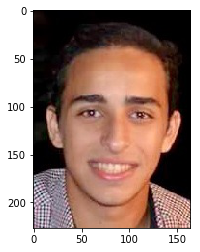

In [50]:
saver = tf.train.Saver()
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image as im
from keras.preprocessing import image

%matplotlib inline
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
new_dimensions = (32, 32)
image_path = 'testing/4_cropped.JPG'
image2 = paths_to_tensor([image_path])

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    
    pil_im = Image.open(image_path, 'r')
    imshow(np.asarray(pil_im))
    
    ret = sess.run(prediction, feed_dict={
        X: batch_x,
        keep_prob: 1.0
    })





  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00, 468.17it/s]

INFO:tensorflow:Restoring parameters from model.ckpt


Model restored.
Mina


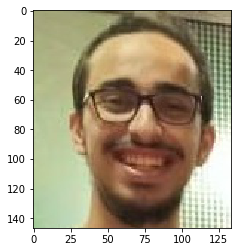

In [61]:
image_path = 'testing/mina.jpg'
image2 = paths_to_tensor([image_path])
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    pil_im = Image.open(image_path, 'r')
    imshow(np.asarray(pil_im))

    ret1 = sess.run(prediction, feed_dict={
        X: image2,
        keep_prob: 1.0
    })
    print(array_names[np.argmax(ret1[0])])






  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00, 338.03it/s]

INFO:tensorflow:Restoring parameters from model.ckpt


Model restored.
Jack


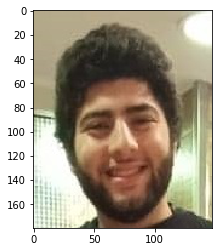

In [62]:
image_path = 'testing/jack.jpg'
image2 = paths_to_tensor([image_path])
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    pil_im = Image.open(image_path, 'r')
    imshow(np.asarray(pil_im))

    ret1 = sess.run(prediction, feed_dict={
        X: image2,
        keep_prob: 1.0
    })
    print(array_names[np.argmax(ret1[0])])


Nardeen


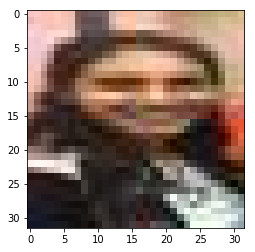

In [52]:
    i=0
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])


Jack


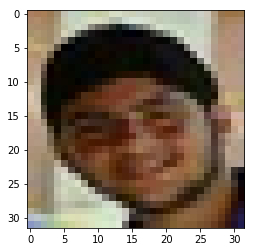

In [53]:
    i=1
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])


Mostafa


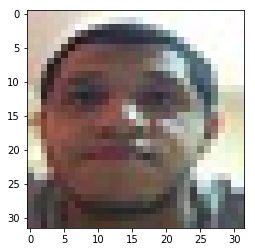

In [54]:
    i=9
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])


Mina


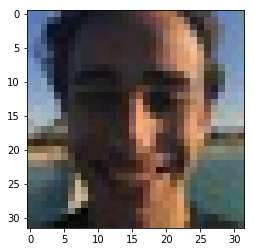

In [55]:
    i=3
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])


Nardeen


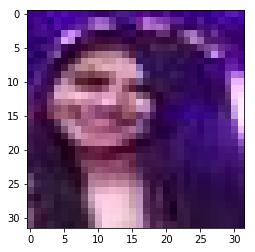

In [56]:
    i=10
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])


Khaled


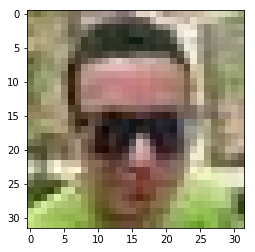

In [57]:
    i=14
    pil_im = Image.open(train_files[i], 'r')
    imshow(np.asarray(pil_im))
    print(array_names[np.argmax(ret[i])])
